In [1]:
#First let's open the simulation file
from tools import *
import pickle

with open('../MicroBooNE/Simulation.pkl', 'rb') as infile:
  data = pickle.load(infile)

In [2]:
#Let's look at the variables contained in the dataset

for variable_name in list(data):
  print(variable_name)

Distance to closest cosmic ray track
Length of lepton track
Distance to longest track
Simulation category
Topological muon ML score
End position of lepton track z component
End position of lepton track y component
End position of lepton track x component
Track vs shower ML score
Particle ID LLh
Start position of lepton track z component
Start position of lepton track y component
Start position of lepton track x component
Interaction vertex position x component
Interaction vertex position y component
Interaction vertex position z component
Total energy
Subevent
Muon momenutm (length estimate)
Muon momenutm (scattering estimate)
Simulation weight
Simulated neutrino energy
Simulated neutrino flight distance
Simulated muon momentum


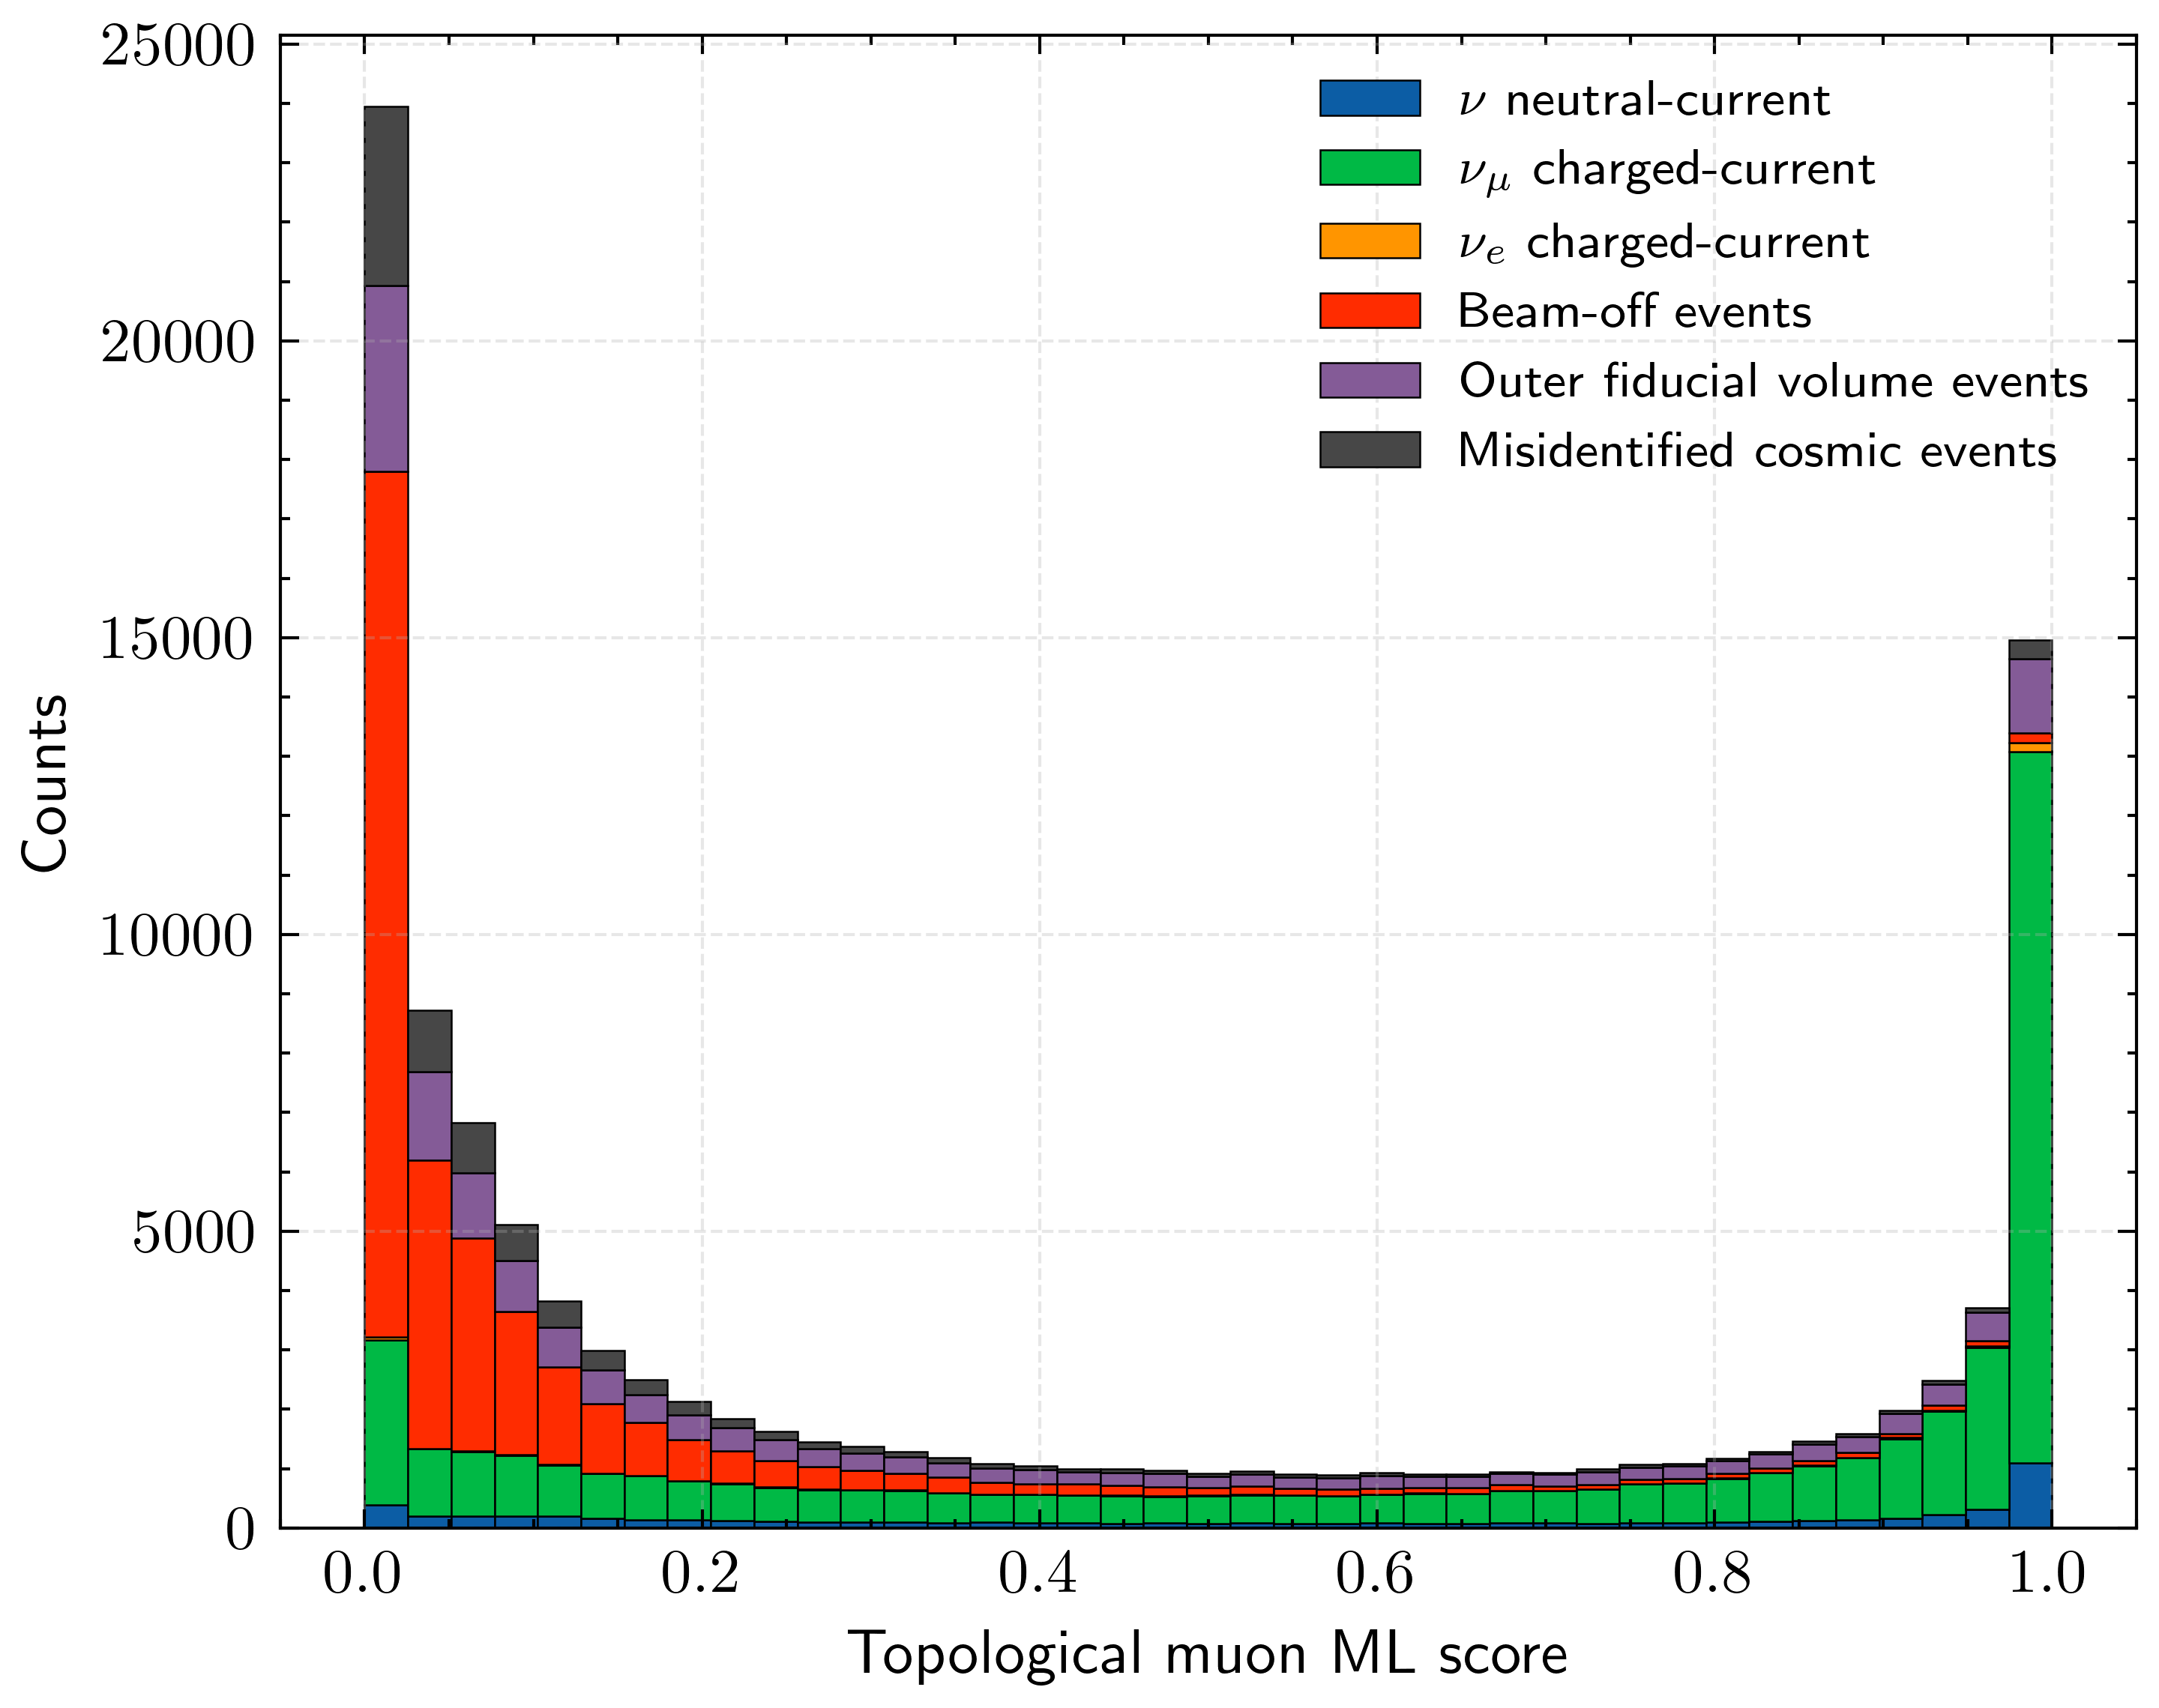

In [40]:
variable = 'Topological muon ML score'
label = 'Topological muon ML score'

cats = {
    31: r'$\nu$ neutral-current',
    21: r'$\nu_\mu$ charged-current',
    10: r'$\nu_e$ charged-current',
    7:  'Beam-off events',
    5:  'Outer fiducial volume events',
    4:  'Misidentified cosmic events'
}

bins = np.linspace(0, 1, 40)
use_weight = True   # change here

plt.figure(dpi=600, figsize=(5,4))

stack_vals = []
stack_weights = []

for cat in cats:
    mask = data['Simulation category'] == cat
    stack_vals.append(data.loc[mask, variable])

    if use_weight:
        stack_weights.append(data.loc[mask, 'Simulation weight'])

weights_arg = stack_weights if use_weight else None

plt.hist(
    stack_vals,
    bins=bins,
    weights=weights_arg,
    stacked=True,
    histtype='bar',
    label=list(cats.values()),
    edgecolor='black',
    linewidth=0.3
)

plt.xlabel(label)
plt.ylabel('Counts')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


# What is the best cut-off value to use? 

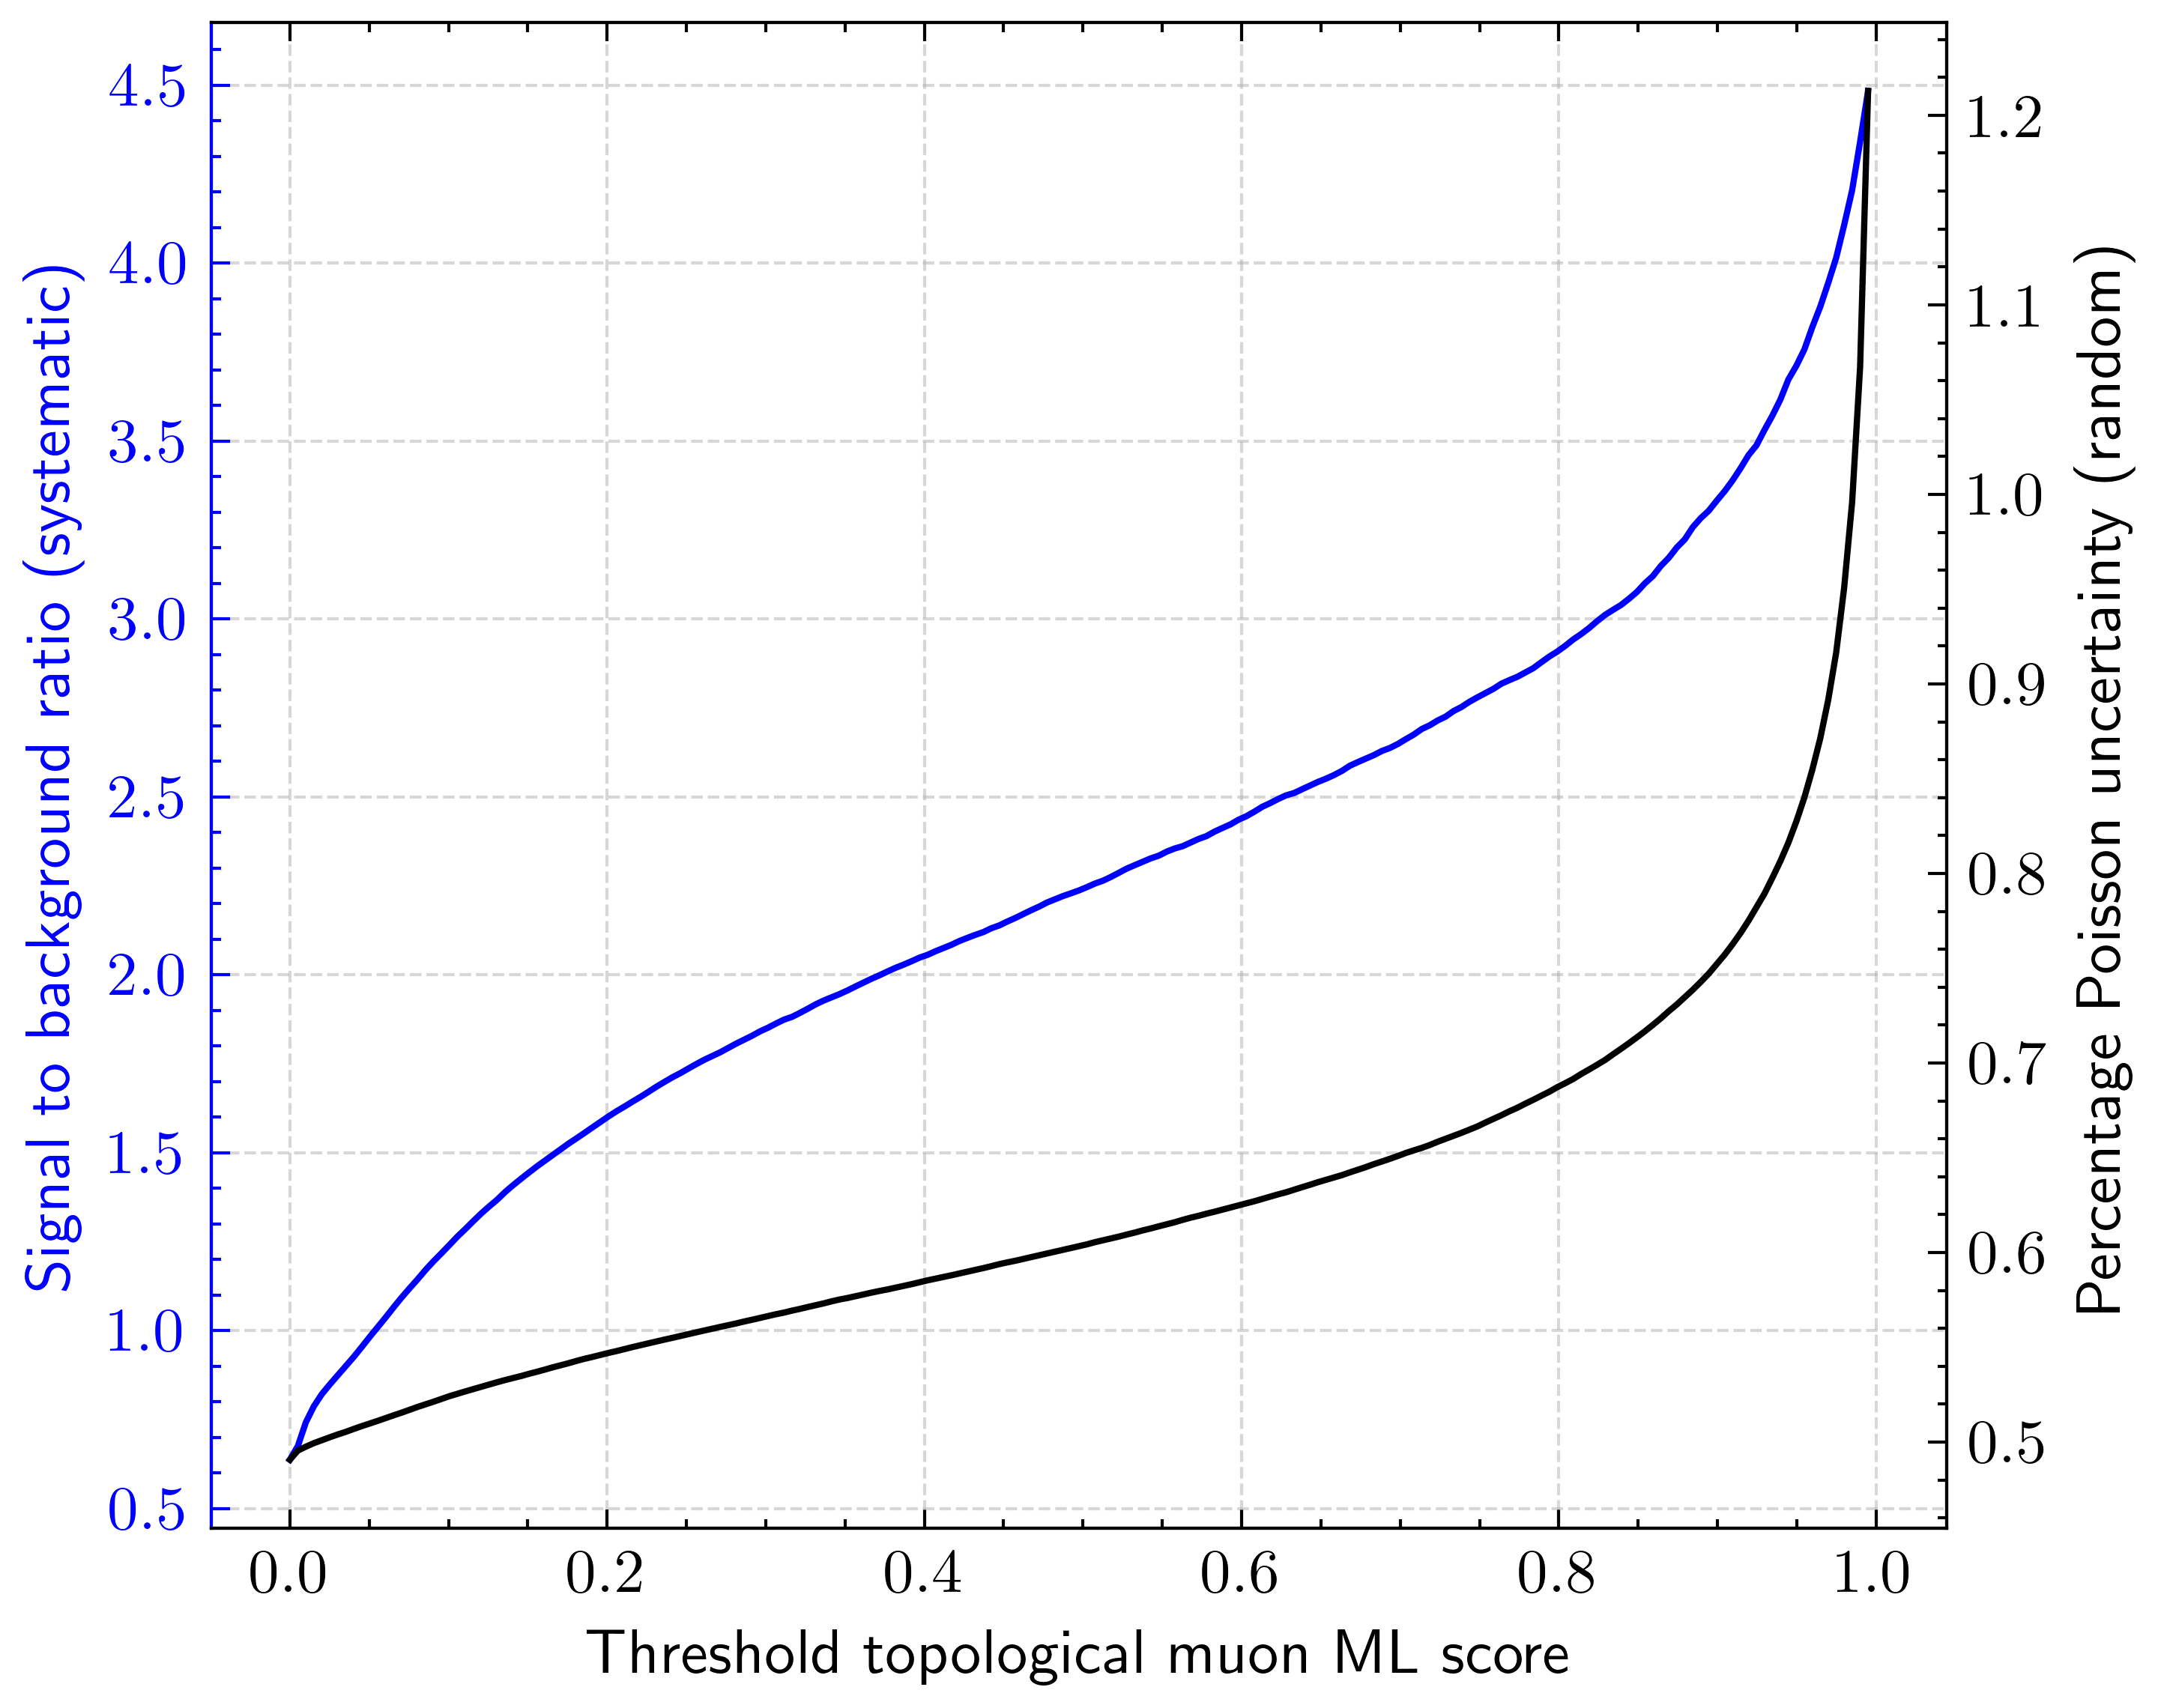

In [101]:
variable = 'Topological muon ML score'

sig_mask = data['Simulation category'] == 21
bkg_mask = data['Simulation category'] != 21

scores_sig  = data.loc[sig_mask, variable]
weights_sig = data.loc[sig_mask, 'Simulation weight']

scores_bkg  = data.loc[bkg_mask, variable]
weights_bkg = data.loc[bkg_mask, 'Simulation weight']

thresholds = np.linspace(0, 1, 200)

snr = []
fractional_unc = []

for t in thresholds:
    sig_sel = weights_sig[scores_sig > t].sum()
    bkg_sel = weights_bkg[scores_bkg > t].sum()

    # S/B with safe handling of zero background
    if bkg_sel > 0:
        snr.append(sig_sel / bkg_sel)
    else:
        snr.append(np.nan)

    # fractional Poisson uncertainty on signal
    if sig_sel > 0:
        fractional_unc.append(1 / np.sqrt(sig_sel))
    else:
        fractional_unc.append(np.nan)

fig, ax1 = plt.subplots(figsize=(5,4), dpi=600)

# Left axis: S/B
ax1.plot(thresholds, snr, color='blue')
ax1.set_xlabel('Threshold topological muon ML score')
ax1.set_ylabel('Signal to background ratio (systematic)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue',  which='both', color='blue')
ax1.spines['left'].set_color('blue')
ax1.grid(alpha=0.5, linestyle='--')


# Right axis: fractional uncertainty
ax2 = ax1.twinx()
ax2.plot(thresholds, np.array(fractional_unc)*100, color='black')
ax2.set_ylabel('Percentage Poisson uncertainty (random)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax2.spines['left'].set_color('blue')

plt.tight_layout()
plt.show()


In [102]:
combo = []
for t in thresholds:
    S = weights_sig[scores_sig > t].sum()
    B = weights_bkg[scores_bkg > t].sum()
    if B > 0 and S > 0:
        combo.append((S**1.5)/B)
    else:
        combo.append(np.nan)

combo = np.array(combo)
opt_idx = np.nanargmax(combo)
opt_threshold = thresholds[opt_idx]

print("Optimal threshold =", opt_threshold)


Optimal threshold = 0.9447236180904522
